In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
seaborn.set_style('dark')
np.set_printoptions(precision=3)

%matplotlib inline

In [2]:
import sklearn
import sklearn.metrics
import sklearn.grid_search
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.preprocessing
import sklearn.pipeline
import pescador

In [3]:
import glob

In [4]:
def load_file(filename, n_pos=32, n_neg=32):
    
    data = np.load(filename)
    
    d = data['X'].shape[1]
    
    if n_pos is None:
        return data['X'], data['Y']
    
    
    positives = np.flatnonzero(data['Y'])
    negatives = np.flatnonzero(1-data['Y'])
    n_pos = min(n_pos, len(positives))
    n_neg = min(n_neg, len(negatives))
    
    X = np.empty((n_pos + n_neg, d), dtype=np.float32)
    Y = np.zeros((n_pos + n_neg), dtype=np.int32)
    
    if n_pos > 0:
        idx_pos = np.random.choice(positives, size=n_pos, replace=False)
    
        X[:n_pos] = np.take(data['X'], idx_pos, axis=0)
        Y[:n_pos] = 1
    
    if n_neg > 0:
        idx_neg = np.random.choice(negatives, size=n_neg, replace=False)
        X[n_pos:] = np.take(data['X'], idx_neg, axis=0)
    
    return X, Y

In [5]:
def load_batch(files, n_pos=32, n_neg=32):
    
    X = []
    Y = []
    
    for fn in files:
        _x, _y = load_file(fn, n_pos=n_pos, n_neg=n_neg)
        X.append(_x)
        Y.append(_y)
        
    X = np.concatenate(X, axis=0)
    Y = np.concatenate(Y, axis=0)
    
    return X, Y

In [6]:
files = sorted(glob.glob('../data/labeled_features/SALAMI_*.npz'))
#files = sorted(glob.glob('../data/labeled_features/Isophonics_*.npz'))

In [7]:
filesplitter = sklearn.cross_validation.ShuffleSplit(len(files), n_iter=1, test_size=0.20, random_state=5)
_files = np.asarray(files)

In [8]:
for trainf, testf in filesplitter:
    
    print 'Loading training data...'
    X_train, Y_train = load_batch([_files[_] for _ in trainf],
                                 n_pos=128,
                                 n_neg=128)
    
    estimator = sklearn.linear_model.SGDClassifier(loss='log',
                                                   verbose=1)
    
    feature = sklearn.preprocessing.StandardScaler()
    
    _model = sklearn.grid_search.GridSearchCV(estimator,
                                             {'alpha': np.logspace(-3, 3, num=6, endpoint=False),
                                             'penalty': ['l1', 'l2', 'elasticnet']},
                                             n_jobs=3, verbose=1)
    
    model = sklearn.pipeline.Pipeline([('scaler', feature), ('predictor', _model)])
    
    model.fit(X_train, Y_train)
    
    print 'Loading testing data...'
    X_test, Y_test = load_batch([_files[_] for _ in testf],
                                n_pos=None,
                                n_neg=None)

Loading training data...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=3)]: Done   1 jobs       | elapsed:    7.2s
[Parallel(n_jobs=3)]: Done  50 out of  54 | elapsed:  1.7min remaining:    8.3s
[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed:  1.8min finished


-- Epoch 1
Norm: 0.10, NNZs: 924, Bias: -0.258349, T: 110972, Avg. loss: 0.611879-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 408.85, NNZs: 80, Bias: -0.054550, T: 73981, Avg. loss: 20.191210Norm: 412.39, NNZs: 67, Bias: -0.048610, T: 73982, Avg. loss: 20.194628Norm: 402.52, NNZs: 79, Bias: -0.144931, T: 73981, Avg. loss: 21.164725


Total training time: 1.03 seconds.
Total training time: 1.22 seconds.
Total training time: 0.83 seconds.
-- Epoch 2
-- Epoch 2
-- Epoch 2
Norm: 410.08, NNZs: 59, Bias: -0.024523, T: 147962, Avg. loss: 10.405516Norm: 413.63, NNZs: 64, Bias: 0.028100, T: 147964, Avg. loss: 10.410255Norm: 403.69, NNZs: 70, Bias: -0.059400, T: 147962, Avg. loss: 10.891224


Total training time: 1.96 seconds.
Total training time: 2.35 seconds.
Total training time: 1.68 seconds.
-- Epoch 3
-- Epoch 3
-- Epoch 3
Norm: 410.47, NNZs: 94, Bias: 0.134704, T: 221943, Avg. loss: 7.139518Norm: 414.03, NNZs: 67, Bias: 0.028571, T: 221946, Avg. loss: 7.145162Norm: 404.07, NNZs: 89, Bias: -0.001

In [9]:
w = model.steps[1][1].best_estimator_.coef_[0]

In [10]:
w = w.reshape((-1, 84))

<matplotlib.colorbar.Colorbar instance at 0x7f2960185fc8>

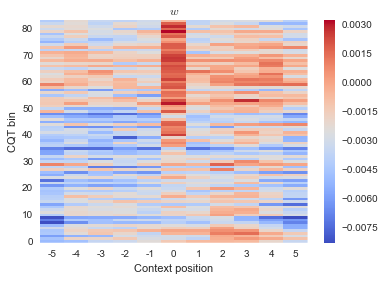

In [19]:
plt.imshow(w.T, aspect='auto', interpolation='none', cmap='coolwarm', origin='lower')
plt.ylabel('CQT bin')
plt.xlabel('Context position')
plt.title('$w$')
plt.xticks(np.arange(11), np.arange(-5, 6))
plt.colorbar()

In [12]:
print sklearn.metrics.classification_report(Y_train, model.predict(X_train))

             precision    recall  f1-score   support

          0       0.68      0.58      0.62     51620
          1       0.67      0.76      0.72     59352

avg / total       0.68      0.68      0.67    110972



In [28]:
sklearn.metrics.accuracy_score(Y_train, model.predict(X_train))

0.67638683631907148

In [21]:
Y_pred = [model.predict(xt) for xt in X_test]

In [24]:
Y_pred = np.concatenate(Y_pred, axis=0)

In [27]:
print sklearn.metrics.classification_report(Y_test, Y_pred)

             precision    recall  f1-score   support

          0       0.72      0.63      0.67    252218
          1       0.61      0.69      0.65    206061

avg / total       0.67      0.66      0.66    458279



In [29]:
sklearn.metrics.accuracy_score(Y_test, Y_pred)

0.66006297473809628